In [1]:
# Group 7 - Noah L. Schrick

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from dmba import regressionSummary
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing


In [4]:
# Import data
timing_df = pd.read_csv('timing.csv')

# Exploratory Analysis

## Parallel Coordinates Plot

In [5]:
import plotly.express as px
overall_df = timing_df[['nodes', 'exploit', 'appl', 'load', 'runtime']]
overall_df['load'] = overall_df['load'].replace(395,0)
overall_df['load'] = overall_df['load'].replace(296,25)
overall_df['load'] = overall_df['load'].replace(197,50)
overall_df['load'] = overall_df['load'].replace(79,75)
overall_df['load'] = overall_df['load'].replace(1,100)

# , [296,25], [197,50], [79,75], [1,100]
fig = px.parallel_coordinates(overall_df, color="runtime", labels={"runtime": "runtime",
                "nodes": "nodes", "exploit": "exploit",
                "appl": "appl", "load": "load", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
#fig.show()

/tmp/ipykernel_2245604/3065867443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['load'] = overall_df['load'].replace(395,0)
/tmp/ipykernel_2245604/3065867443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['load'] = overall_df['load'].replace(296,25)
/tmp/ipykernel_2245604/3065867443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

## VIF

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictors = ['nodes', 'exploit', 'appl', 'load']
X = timing_df[predictors]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)


   feature       VIF
0    nodes  3.963066
1  exploit  1.105725
2     appl  2.467626
3     load  5.344994


## Plot raw features with outcome

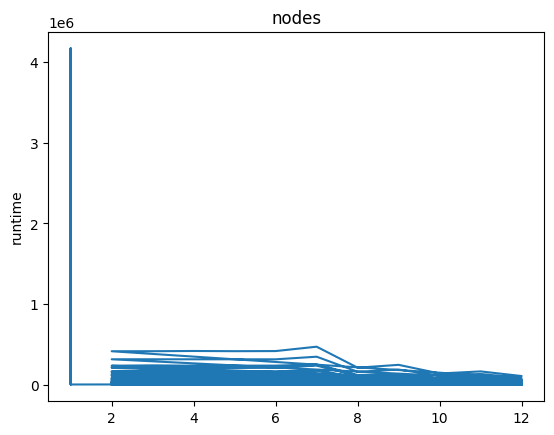

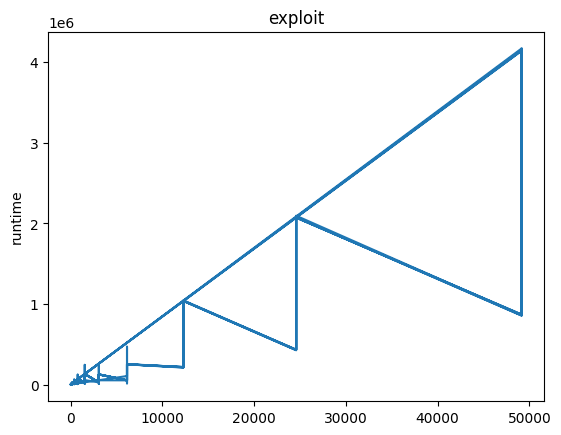

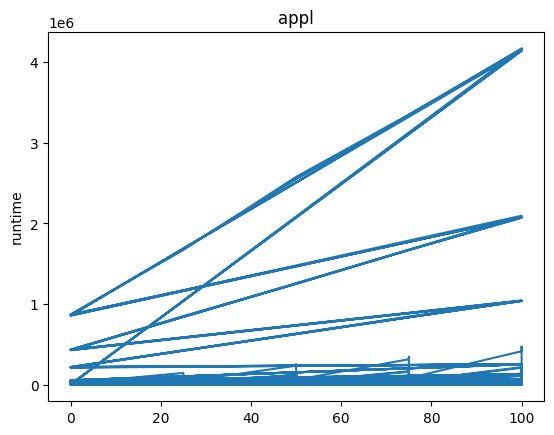

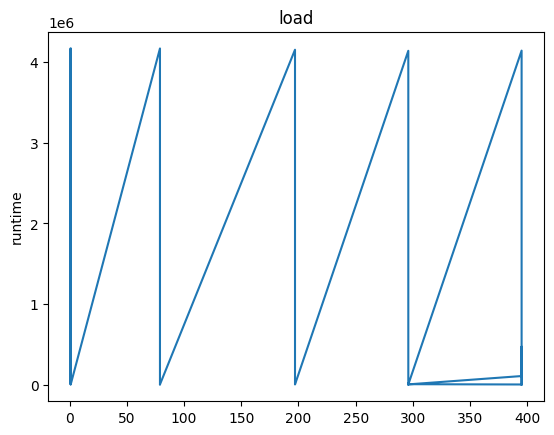

In [7]:
for feat in ['nodes', 'exploit', 'appl', 'load']:
    plt.figure()
    plt.plot(timing_df[feat], timing_df['runtime'])
    plt.title(feat)
    plt.ylabel('runtime')

## Show avg timing data for each var step (EX: Avg time for 12 nodes, 11...1, Avg time for 6 exploits...49152)


/tmp/ipykernel_2245604/3831858898.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2245604/3831858898.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2245604/3831858898.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

<Axes: title={'center': 'Database Load vs Runtime'}, xlabel='Database Load (%)', ylabel='Runtime (ms)'>

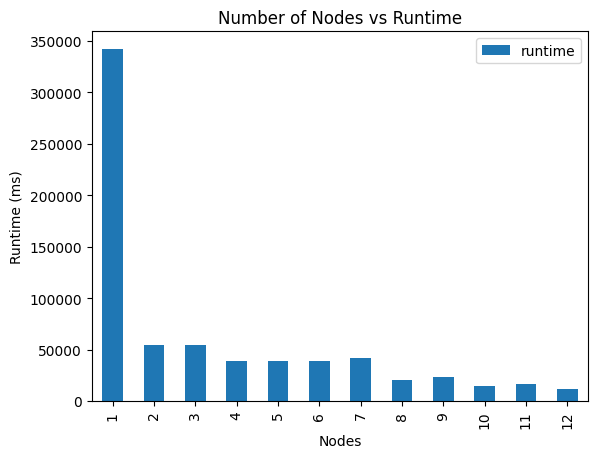

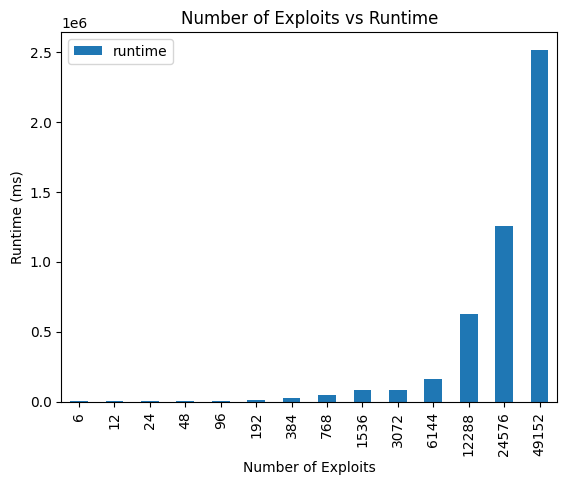

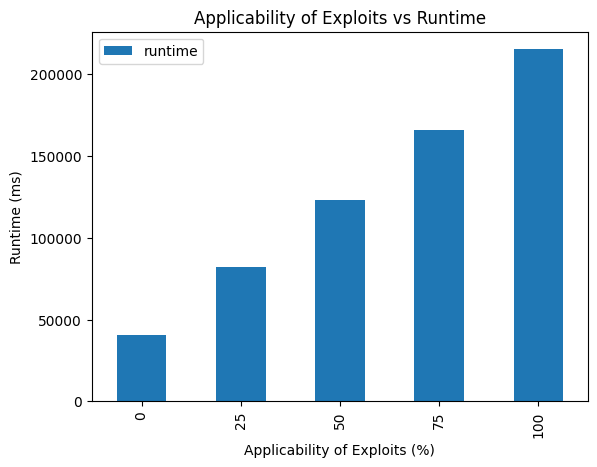

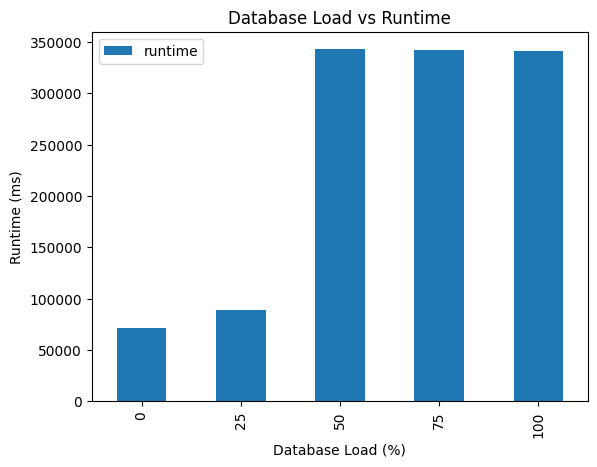

In [8]:
node_pivot = timing_df.pivot_table(index=["nodes"], values=["runtime"], aggfunc='mean')
exploit_pivot = timing_df.pivot_table(index=["exploit"], values=["runtime"], aggfunc='mean')
appl_pivot = timing_df.pivot_table(index=["appl"], values=["runtime"], aggfunc='mean')

overall_df['load'] = overall_df['load'].replace(395,0)
overall_df['load'] = overall_df['load'].replace(296,25)
overall_df['load'] = overall_df['load'].replace(197,50)
overall_df['load'] = overall_df['load'].replace(79,75)
overall_df['load'] = overall_df['load'].replace(1,100)
load_pivot = overall_df.pivot_table(index=["load"], values=["runtime"], aggfunc='mean')

node_pivot.plot(kind='bar', title='Number of Nodes vs Runtime', ylabel='Runtime (ms)', xlabel="Nodes")
exploit_pivot.plot(kind='bar', title='Number of Exploits vs Runtime', ylabel='Runtime (ms)', xlabel="Number of Exploits")
appl_pivot.plot(kind='bar', title='Applicability of Exploits vs Runtime', ylabel='Runtime (ms)', xlabel="Applicability of Exploits (%)")
load_pivot.plot(kind='bar', title='Database Load vs Runtime', ylabel='Runtime (ms)', xlabel="Database Load (%)")


## Correlation and Matrix Plot

<Axes: >

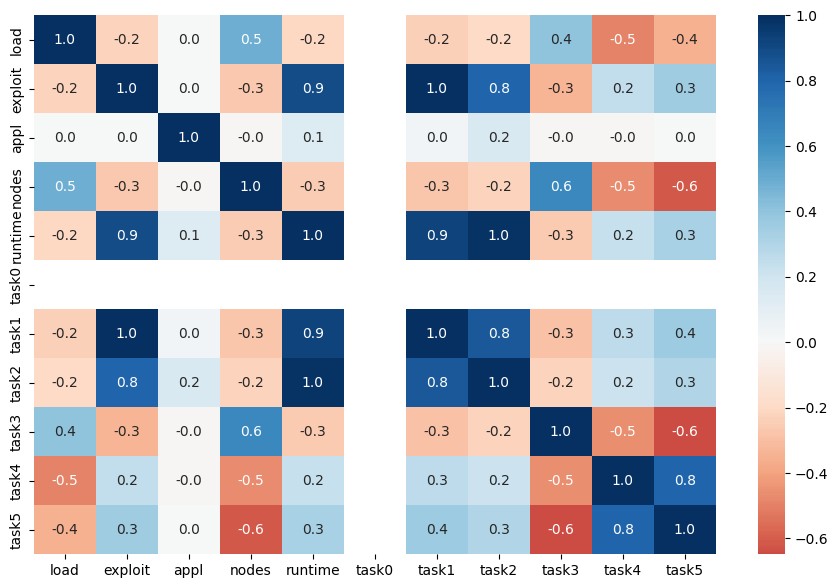

In [9]:
timing_corr = timing_df.corr().round(3)
# print(timing_corr)
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(timing_corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

# Speedup and Efficiency

In [10]:
# Add speedup and efficiency columns
timing_df['speedup'] = np.nan
timing_df['efficiency'] = np.nan
for idx, row in timing_df.iterrows():
    nodes,exploits,appl,load = row['nodes'], row['exploit'], row['appl'], row['load']
    timing_df.at[idx,'speedup'] = timing_df['runtime'][timing_df['nodes'] == 1][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]/timing_df['runtime'][timing_df['nodes'] == nodes][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]
    timing_df.at[idx,'efficiency'] = timing_df['runtime'][timing_df['nodes'] == 1][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]/(timing_df['runtime'][timing_df['nodes'] == nodes][timing_df['exploit']==exploits][timing_df['appl']==appl][timing_df['load']==load].values[0]*nodes)

## Min, Max, Mean: Nodes

<Axes: title={'center': 'Minimum, Maximum, and Mean Speedups of MPI Tasking\n for Increasing Problem Sizes'}, xlabel='Number of Nodes', ylabel="Speedup (Amdahl's)">

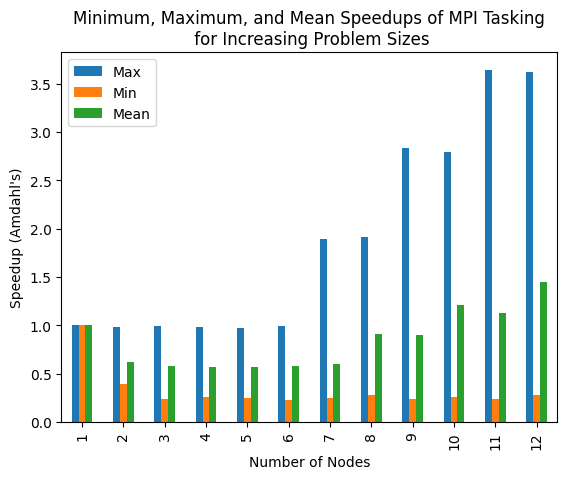

In [11]:
res_spd_df = pd.DataFrame(timing_df.pivot_table(index=["nodes"], values=["speedup"], aggfunc=['max', 'min', 'mean']).to_records())
res_spd_df = res_spd_df.set_axis(['Nodes', 'Max', 'Min', 'Mean'], axis=1)
res_spd_df.plot(kind='bar', x='Nodes', title='Minimum, Maximum, and Mean Speedups of MPI Tasking\n for Increasing Problem Sizes', ylabel="Speedup (Amdahl's)", xlabel="Number of Nodes")

<Axes: title={'center': 'Minimum, Maximum, and Mean Efficiencies of MPI Tasking\n for Increasing Problem Sizes'}, xlabel='Number of Nodes', ylabel='Efficiency'>

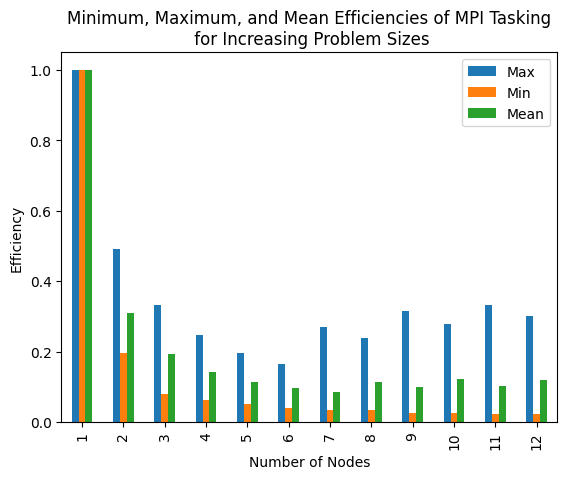

In [12]:
res_eff_df = pd.DataFrame(timing_df.pivot_table(index=["nodes"], values=["efficiency"], aggfunc=['max', 'min', 'mean']).to_records())
res_eff_df = res_eff_df.set_axis(['Nodes', 'Max', 'Min', 'Mean'], axis=1)
res_eff_df.plot(kind='bar', x='Nodes', title='Minimum, Maximum, and Mean Efficiencies of MPI Tasking\n for Increasing Problem Sizes', ylabel="Efficiency", xlabel="Number of Nodes")

## Exploits, Appl, Nodes

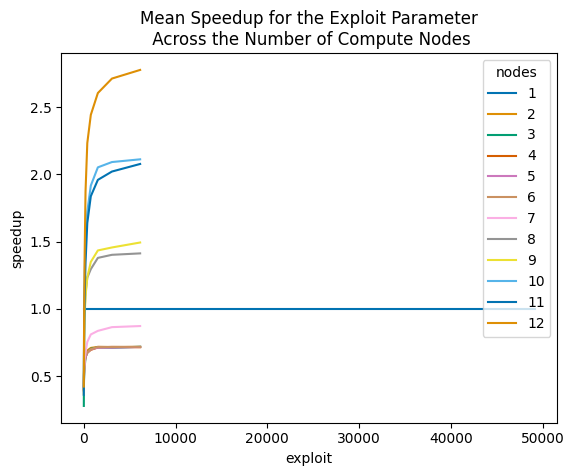

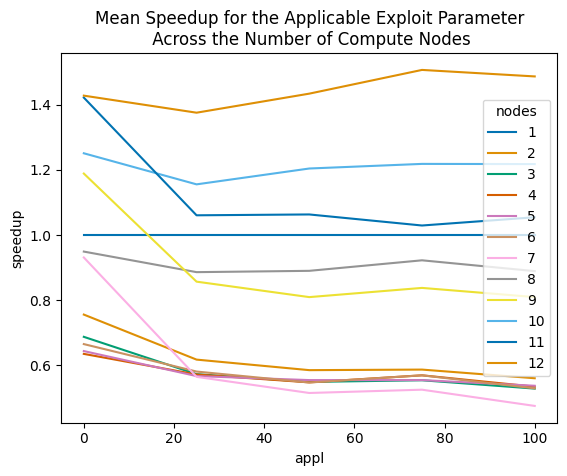

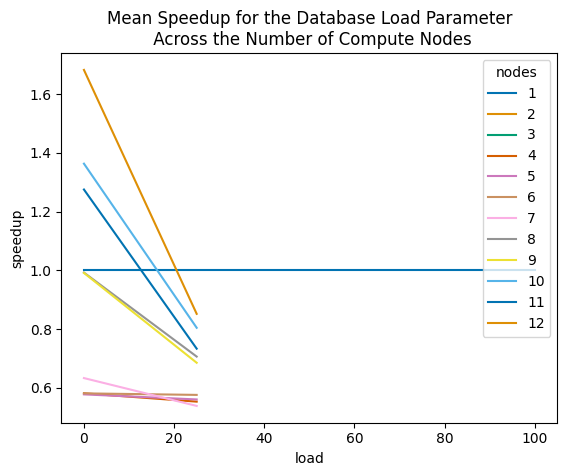

In [13]:
# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?
tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["exploit", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Speedup for the Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["appl", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Speedup for the Applicable Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["speedup"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Speedup for the Database Load Parameter\n Across the Number of Compute Nodes')
plt.show()

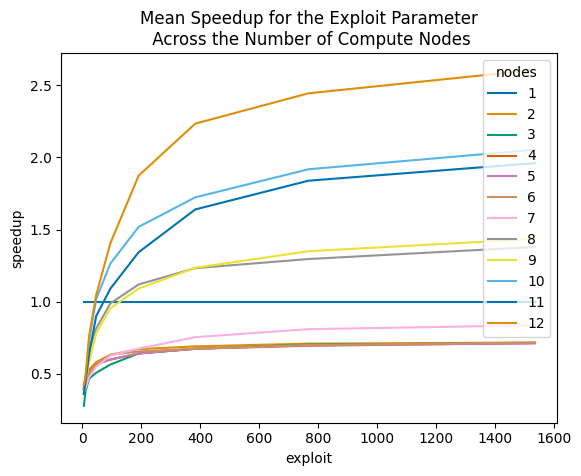

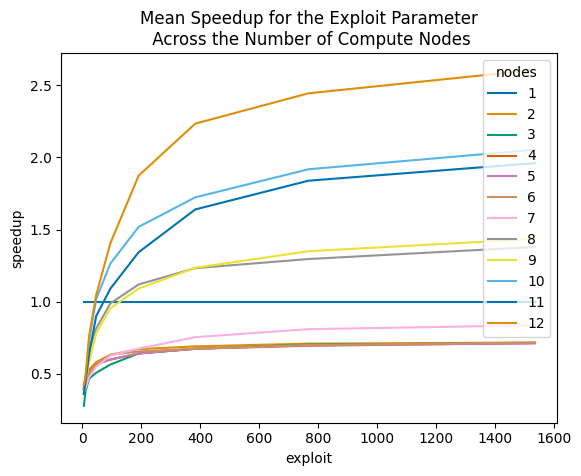

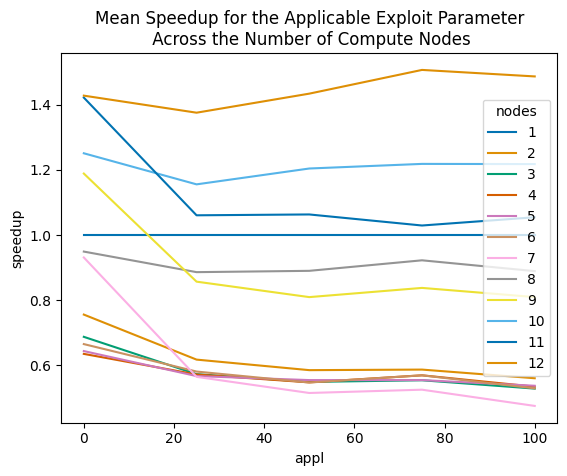

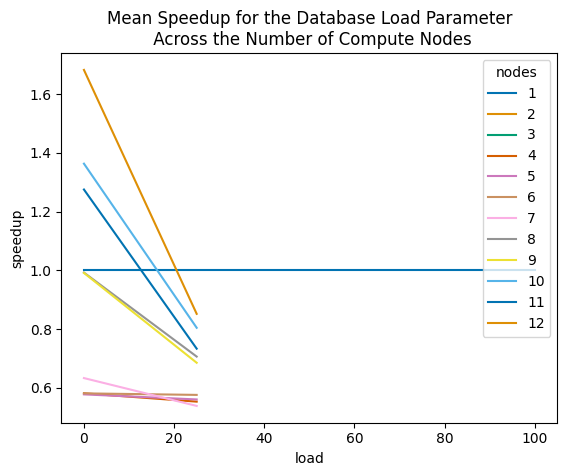

In [16]:
# HARDCODING/LIMITING AX FOR PRELIM RES ONLY

# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?
new_tmp_df = timing_df.drop(timing_df[timing_df.exploit > 3000].index)
new_tmp_pv = pd.DataFrame(new_tmp_df.pivot_table(index=["exploit", "nodes"], values=["speedup"], aggfunc='mean').to_records())

ax = sns.lineplot(x="exploit", y="speedup", hue="nodes", palette="colorblind", data=new_tmp_pv).set(title='Mean Speedup for the Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()



new_tmp_pv = pd.DataFrame(new_tmp_df.pivot_table(index=["exploit", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="speedup", hue="nodes", palette="colorblind", data=new_tmp_pv).set(title='Mean Speedup for the Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

new_tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["appl", "nodes"], values=["speedup"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="speedup", hue="nodes", palette="colorblind", data=new_tmp_pv).set(title='Mean Speedup for the Applicable Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["speedup"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="speedup", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Speedup for the Database Load Parameter\n Across the Number of Compute Nodes')
plt.show()

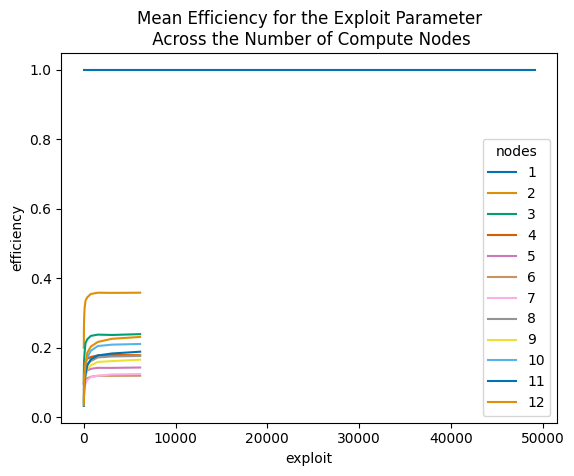

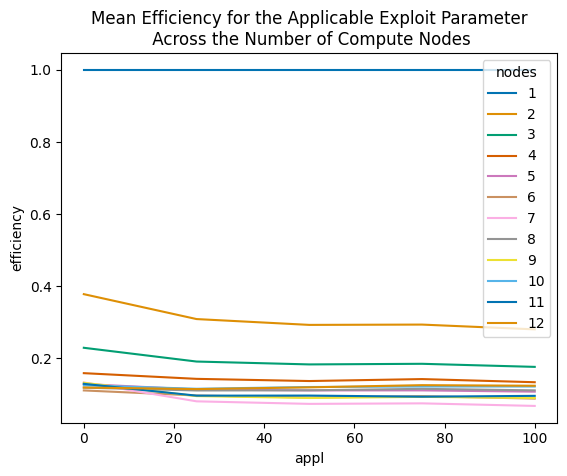

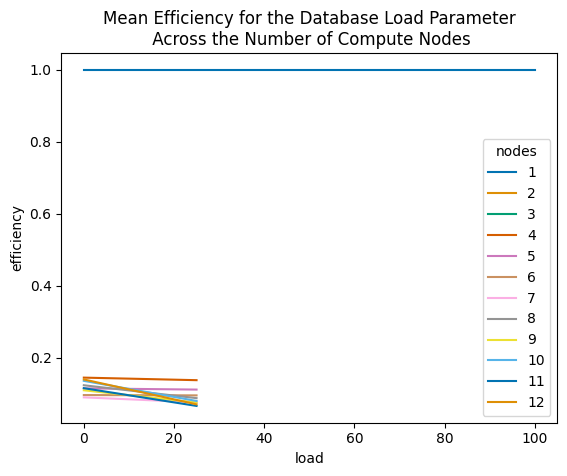

In [13]:
# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?
tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["exploit", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Efficiency for the Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["appl", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Efficiency for the Applicable Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Efficiency for the Database Load Parameter\n Across the Number of Compute Nodes')
plt.show()

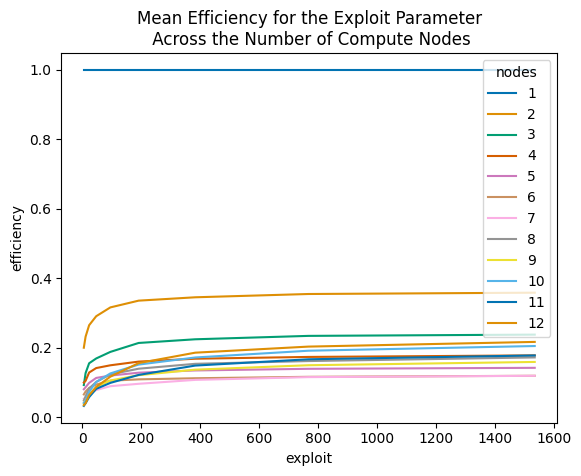

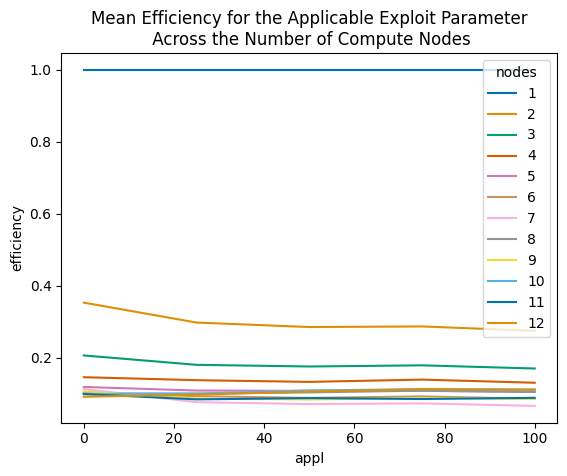

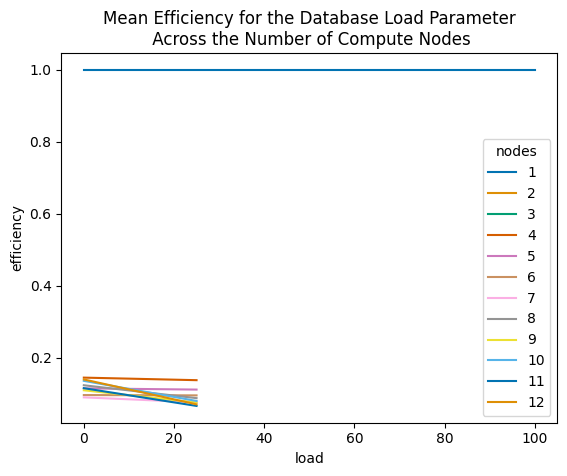

In [17]:
# HARDCODING/LIMITING AX FOR PRELIM RES ONLY

# x axis: exploits
# y axis: speedup and eff
# At each xtick: compartments 0-100 for appl. Min, mean, max for each?

new_tmp_df = timing_df.drop(timing_df[timing_df.exploit > 3000].index)

new_tmp_pv = pd.DataFrame(new_tmp_df.pivot_table(index=["exploit", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="exploit", y="efficiency", hue="nodes", palette="colorblind", data=new_tmp_pv).set(title='Mean Efficiency for the Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

new_tmp_pv = pd.DataFrame(new_tmp_df.pivot_table(index=["appl", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
ax = sns.lineplot(x="appl", y="efficiency", hue="nodes", palette="colorblind", data=new_tmp_pv).set(title='Mean Efficiency for the Applicable Exploit Parameter\n Across the Number of Compute Nodes')
plt.show()

tmp_pv = pd.DataFrame(timing_df.pivot_table(index=["load", "nodes"], values=["efficiency"], aggfunc='mean').to_records())
tmp_pv['load'] = tmp_pv['load'].replace(395,0)
tmp_pv['load'] = tmp_pv['load'].replace(296,25)
tmp_pv['load'] = tmp_pv['load'].replace(197,50)
tmp_pv['load'] = tmp_pv['load'].replace(79,75)
tmp_pv['load'] = tmp_pv['load'].replace(1,100)
ax = sns.lineplot(x="load", y="efficiency", hue="nodes", palette="colorblind", data=tmp_pv).set(title='Mean Efficiency for the Database Load Parameter\n Across the Number of Compute Nodes')
plt.show()

# Linear Regression

## Indiv Vars
### Linear Regression - Overall Runtime
#### Nodes

In [6]:
predictors = ['nodes']
overall_outcome = 'runtime'
norm_df = (timing_df-timing_df.mean())/timing_df.std()
# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  0.00014215703009013694
  Predictor  coefficient
0     nodes    -0.255466

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9457
            Mean Absolute Error (MAE) : 0.4004
          Mean Percentage Error (MPE) : -153.9195
Mean Absolute Percentage Error (MAPE) : 469.3563


#### Exploit

In [7]:
predictors = ['exploit']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  -0.006679327812999215
  Predictor  coefficient
0   exploit     0.876264

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.4366
            Mean Absolute Error (MAE) : 0.1452
          Mean Percentage Error (MPE) : -56.0992
Mean Absolute Percentage Error (MAPE) : 193.5384


#### Appl

In [8]:
predictors = ['appl']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  0.00013241619854788668
  Predictor  coefficient
0      appl     0.123285

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9715
            Mean Absolute Error (MAE) : 0.3759
          Mean Percentage Error (MPE) : 93.5442
Mean Absolute Percentage Error (MAPE) : 116.5608


#### Load

In [9]:
predictors = ['load']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  -0.007075826820466129
  Predictor  coefficient
0      load    -0.183009

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.9620
            Mean Absolute Error (MAE) : 0.3813
          Mean Percentage Error (MPE) : 233.9860
Mean Absolute Percentage Error (MAPE) : 370.4181


## All Vars

### Linear Regression - Overall Runtime

In [10]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)
runtime_lm = LinearRegression()
runtime_lm.fit(train_X, train_y)
# print coefficients
print('intercept ', runtime_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': runtime_lm.coef_}))
# print performance measures
regressionSummary(train_y, runtime_lm.predict(train_X))

intercept  -0.001661686455377755
  Predictor  coefficient
0     nodes    -0.024622
1   exploit     0.877093
2      appl     0.128728
3      load     0.031007

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.4165
            Mean Absolute Error (MAE) : 0.1847
          Mean Percentage Error (MPE) : -112.7836
Mean Absolute Percentage Error (MAPE) : 284.0935


# Nonlinear Regression

## Random Forest

### Nodes

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


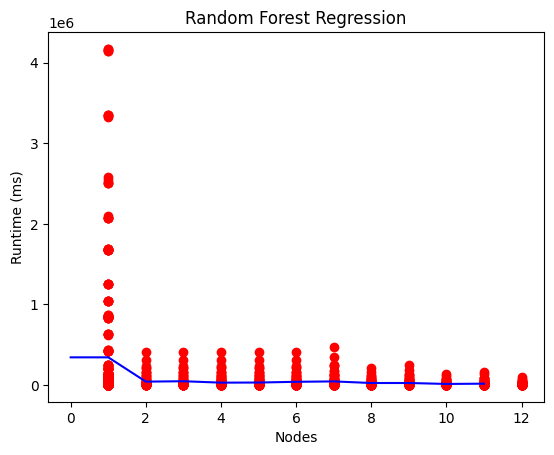

In [20]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['nodes']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 12, 1)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('Nodes')
plt.ylabel('Runtime (ms)')
plt.show()

### Exploit

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


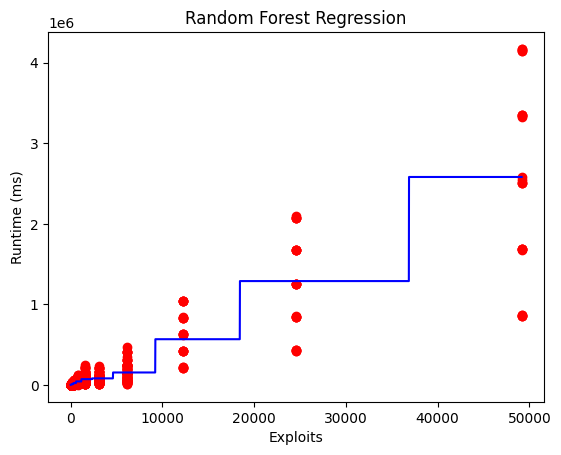

In [19]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['exploit']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 49152, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('Exploits')
plt.ylabel('Runtime (ms)')
plt.show()

### Applicable

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


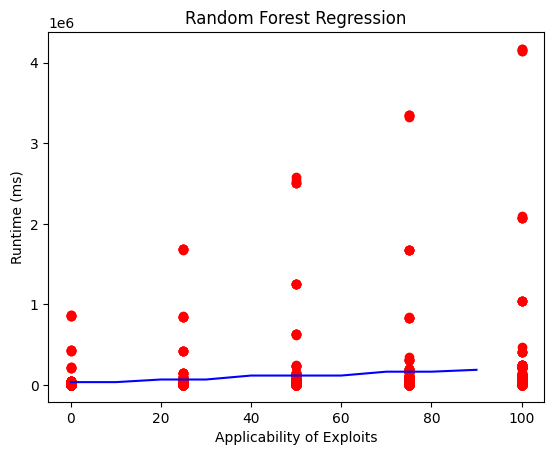

In [23]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['appl']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 100, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('Applicability of Exploits')
plt.ylabel('Runtime (ms)')
plt.show()

### Load

/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


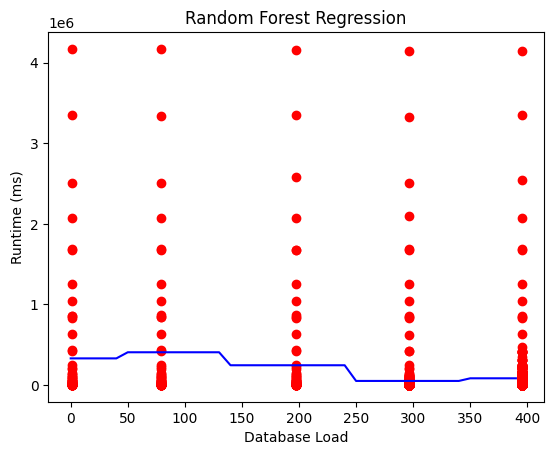

In [25]:
# Random Forest
#predictors = ['nodes', 'exploit', 'appl', 'load']
predictors = ['load']
overall_outcome = 'runtime'

# partition data
X = timing_df[predictors]
overall_y = timing_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train_X, train_y)

X_grid = np.arange(0, 400, 10)
X_grid = X_grid.reshape((len(X_grid),1))
plt.scatter(X, overall_y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('Database Load')
plt.ylabel('Runtime (ms)')
plt.show()

## Gradient Boosting Classifier

The mean squared error (MSE) on test set: 0.0015


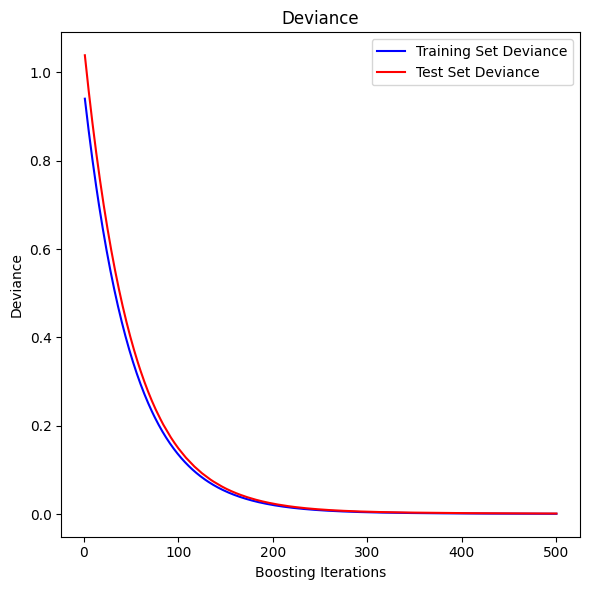

In [26]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(train_X, train_y)

mse = mean_squared_error(valid_y, reg.predict(valid_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(valid_X)):
    test_score[i] = mean_squared_error(valid_y, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Polynomial Regression

[0.4164710671463188,
 0.07930387291011727,
 0.0619084776082051,
 0.04527833425246636,
 0.025332322803174837,
 0.017016832713336875,
 0.01394877632224057,
 0.011642367315970145,
 0.009392082109822862,
 0.013672316013846894,
 0.002975508472526138,
 0.0024905756438819873,
 0.0011070193226399348,
 0.0008166167439355699,
 0.0020619852120506332,
 0.0028208332725586636,
 0.008309883223282157,
 0.012637098728651722,
 0.024207391534791955,
 0.03725217618658084]

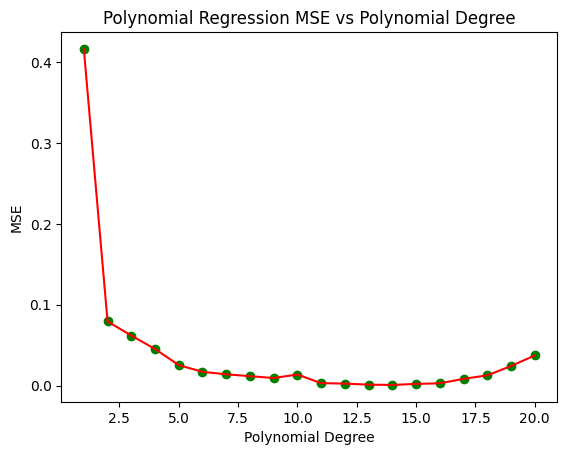

In [32]:
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

plt_mean_squared_error = []
deg_range = range(1,21)
for degree in deg_range:
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(train_X)
    poly.fit(X_poly, train_y)

    regression_model = LinearRegression()
    regression_model.fit(X_poly, train_y)
    y_pred = regression_model.predict(X_poly)
    plt_mean_squared_error.append(mean_squared_error(train_y, y_pred, squared=False))


plt.scatter(deg_range,plt_mean_squared_error, color="green")
plt.plot(deg_range,plt_mean_squared_error, color="red")
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression MSE vs Polynomial Degree')
plt_mean_squared_error

## SVR

In [30]:
# SVR
predictors = ['nodes', 'exploit', 'appl', 'load']
overall_outcome = 'runtime'

# partition data
X = norm_df[predictors]
overall_y = norm_df[overall_outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, overall_y, test_size=0.4, random_state=1)

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=0)
grid.fit(train_X,train_y)

grid_predictions = grid.predict(valid_X)

mean_squared_error(valid_y, grid_predictions, squared=True)

0.00631239915042021